In [6]:
import json
import os
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit


tfd = tfp.distributions
tfb = tfp.bijectors

In [7]:
# helpers
def binomial(n_samples, theta_like=0.7, seed=20):
    np.random.seed(seed)
    data = np.random.binomial(n_samples, theta_like)
    return data

def load_config(config_file="config.json"):

    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def make_conditioned_lp(prior_dist, likelihood_dist, x):
    if type(x) is not int and (x is None or len(x) == 0):
        return lambda z: prior_dist.log_prob(z)
    else:
        def log_prob_fn(z):
            # z: (sample_size,)
            # x: (n_data,)
            z_exp = tf.expand_dims(z, -1)        # (sample_size, 1)
            x_exp = tf.expand_dims(x, 0)         # (1, n_data)
            lp = prior_dist.log_prob(z)          # (sample_size,)
            lp += tf.reduce_sum(likelihood_dist(z_exp).log_prob(x_exp), axis=-1)  # (sample_size,)
            return lp
        return log_prob_fn

def _logistic_normal_mean_std_mc(mu, sigma, n_samples=10_000, seed=0):
    mu = float(np.squeeze(mu))
    sigma = float(np.squeeze(sigma))
    rng = np.random.default_rng(seed)
    z = rng.normal(loc=mu, scale=sigma, size=n_samples)
    theta = expit(z)
    return float(theta.mean()), float(theta.std(ddof=1))

def _trace_locscale_to_theta_moments(loc_trace, scale_trace, n_samples=10_000, seed=0):
    loc_trace = np.asarray(loc_trace, dtype=float)
    scale_trace = np.asarray(scale_trace, dtype=float)
    out_mean = np.empty(loc_trace.shape[0], dtype=float)
    out_std  = np.empty(loc_trace.shape[0], dtype=float)
    for i in range(loc_trace.shape[0]):
        out_mean[i], out_std[i] = _logistic_normal_mean_std_mc(
            loc_trace[i], scale_trace[i], n_samples=n_samples, seed=seed
        )
    return out_mean, out_std

data_gen = binomial

In [8]:
config_file = "beta_config.json"
config = load_config(config_file)

theta_like = config['theta_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
grad_samps = config['grad_samps']
max_iters = 100_000
adam_step = config['adam_step']
transformation = config['transformation']


data = data_gen(n_samples) if n_samples > 0 else 0


In [ ]:
def logistic_normal_mean_std_mc(mu, sigma, n_samples=10_000, seed=1):
    mu = float(np.squeeze(mu))
    sigma = float(np.squeeze(sigma))
    rng = np.random.default_rng(seed)
    z = rng.normal(loc=mu, scale=sigma, size=n_samples)
    theta = expit(z)  # map to (0,1)
    mean = float(theta.mean())
    std = float(theta.std(ddof=1))
    return mean, std

def make_conditioned_lp_binomial_count(alpha_prior, beta_prior, total_count, y_obs, dtype=tf.float32):
    alpha = tf.convert_to_tensor(alpha_prior, dtype=dtype)
    beta  = tf.convert_to_tensor(beta_prior,  dtype=dtype)

    # Cast to float for TFP Binomial internal computations (avoids int32/float32 mismatch errors)
    total_count_f = tf.cast(total_count, dtype)
    y_obs_f       = tf.cast(y_obs, dtype)

    prior = tfd.Beta(concentration1=alpha, concentration0=beta)

    @tf.function(jit_compile=False)  # keep simple; VI can be jit-compiled separately
    def log_prob_fn(theta):
        theta = tf.convert_to_tensor(theta, dtype=dtype)  # theta in (0,1), vector shape [sample_size]
        lp = prior.log_prob(theta)
        lp += tfd.Binomial(total_count=total_count_f, probs=theta).log_prob(y_obs_f)
        return lp

    return log_prob_fn


def build_surrogate(init_params=None):
    init_dict = None
    if init_params is not None:
        init_loc, init_scale = init_params
        init_dict = {
            "loc": tf.convert_to_tensor(init_loc, dtype=tf.float32),
            "scale": tf.convert_to_tensor(init_scale, dtype=tf.float32),
        }

    q = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=(),
        bijector=tfb.Sigmoid(),         # theta = sigmoid(z)
        initial_parameters=init_dict,   # loc/scale of base Normal z
    )
    return q


def make_trace_fn(q):
    def trace_fn(_traceable_quantities):
        base = q.distribution  # Normal(loc, scale) on R (pre-sigmoid)
        return base.loc, base.scale
    return trace_fn


alpha_prior = float(alpha_prior)
beta_prior  = float(beta_prior)
n_samples   = int(n_samples)
data        = int(data)

conditioned_log_prob = make_conditioned_lp_binomial_count(
    alpha_prior=alpha_prior,
    beta_prior=beta_prior,
    total_count=n_samples,
    y_obs=data,
    dtype=tf.float32
)

single_q = build_surrogate()
multi_q  = build_surrogate()

single_trace_fn = make_trace_fn(single_q)
multi_trace_fn  = make_trace_fn(multi_q)


single_trace = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=conditioned_log_prob,
    surrogate_posterior=single_q,
    trainable_variables=single_q.trainable_variables,
    optimizer=tf.optimizers.Adam(),
    num_steps=max_iters,
    seed=0,
    sample_size=1,
    trace_fn=single_trace_fn,
    jit_compile=True,
)

multi_trace = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=conditioned_log_prob,
    surrogate_posterior=multi_q,
    trainable_variables=multi_q.trainable_variables,
    optimizer=tf.optimizers.Adam(),
    num_steps=max_iters,
    seed=0,
    sample_size=100,
    trace_fn=multi_trace_fn,
    jit_compile=True,
)

single_loc_trace, single_scale_trace = single_trace
multi_loc_trace,  multi_scale_trace  = multi_trace


2025-12-29 00:30:40.879225: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:108] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
I0000 00:00:1766986241.670318 15576120 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


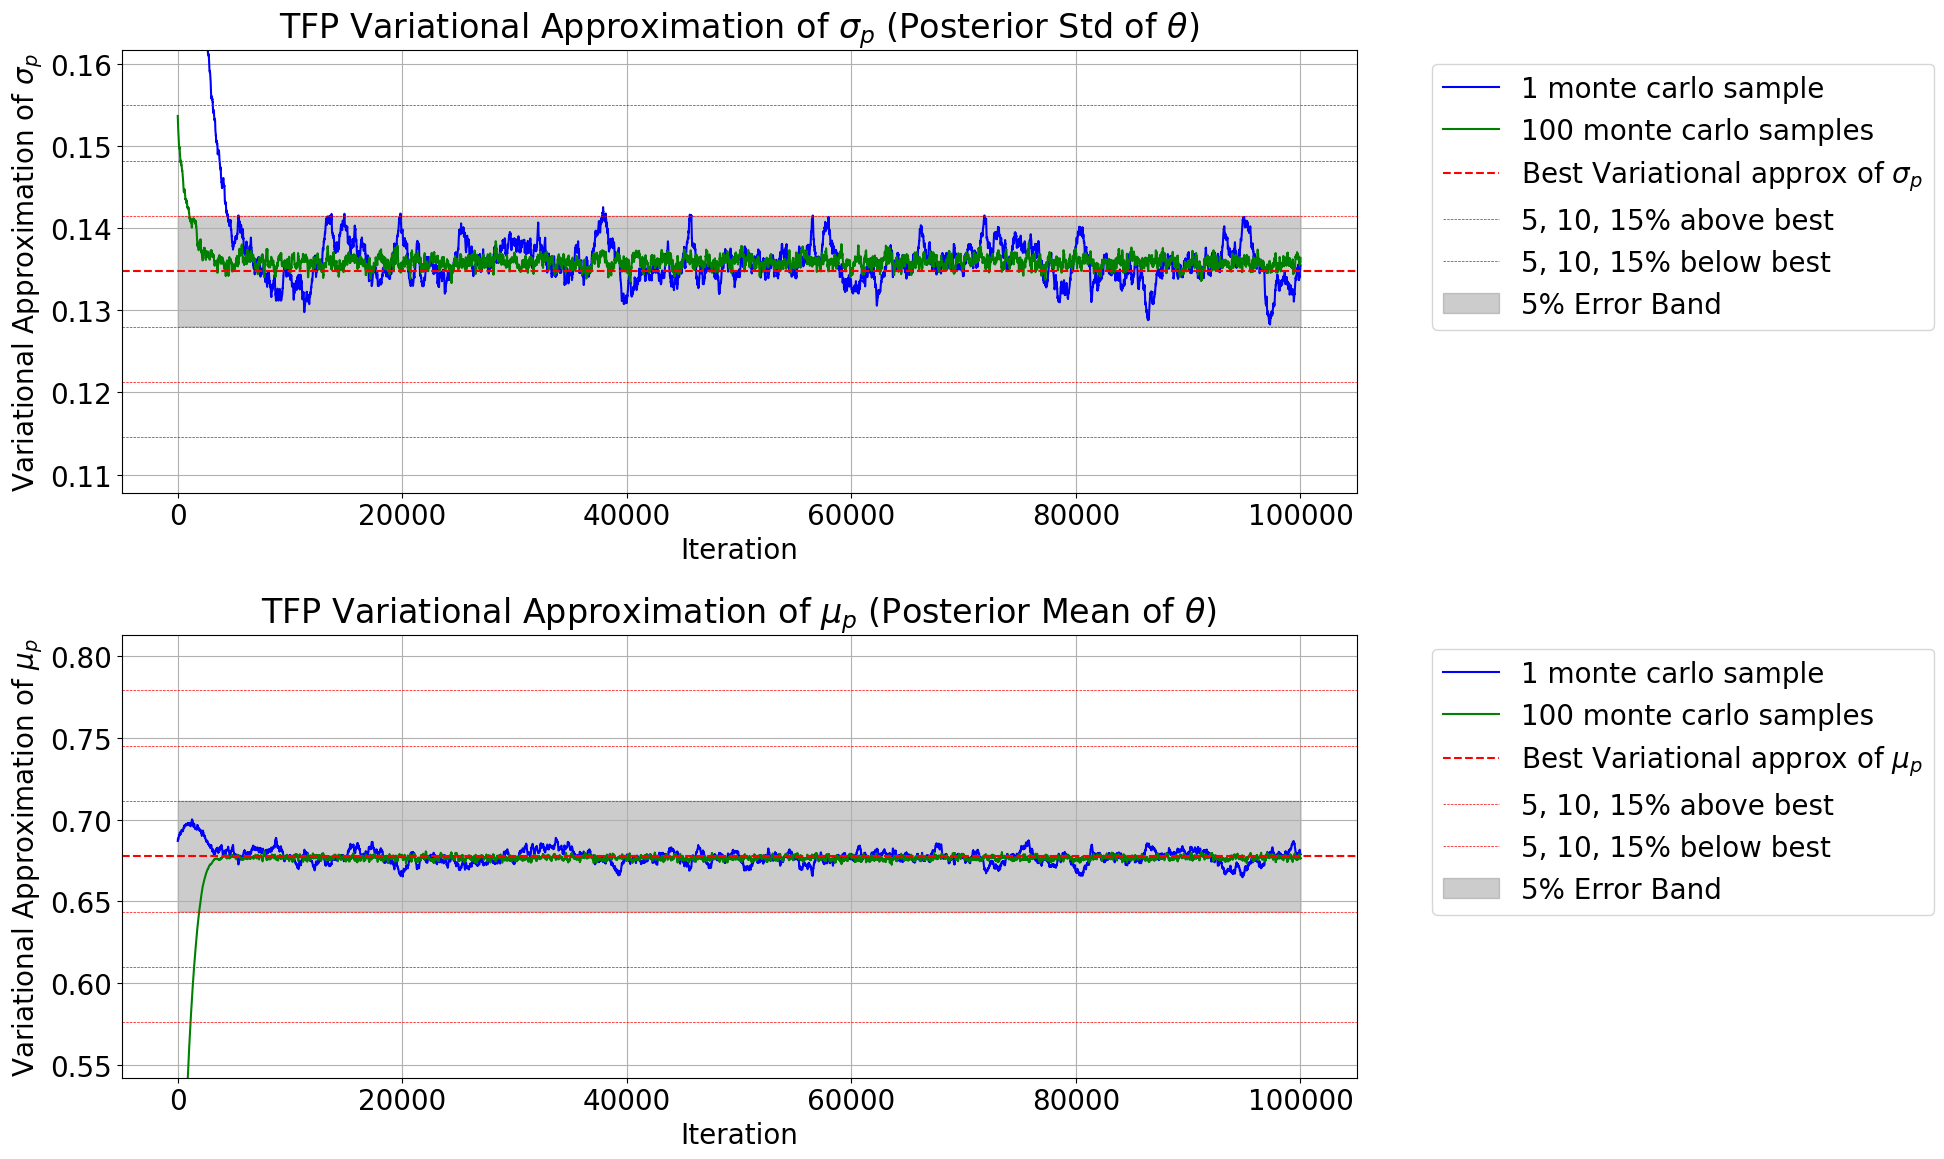

In [11]:
single_loc_trace   = np.asarray(single_loc_trace)
single_scale_trace = np.asarray(single_scale_trace)
multi_loc_trace    = np.asarray(multi_loc_trace)
multi_scale_trace  = np.asarray(multi_scale_trace)

single_mus, single_stds = [], []
multi_mus, multi_stds = [], []

for i in range(len(single_loc_trace)):
    m, s = logistic_normal_mean_std_mc(single_loc_trace[i], single_scale_trace[i], n_samples=10_000, seed=0)
    single_mus.append(m)
    single_stds.append(s)

    m, s = logistic_normal_mean_std_mc(multi_loc_trace[i], multi_scale_trace[i], n_samples=10_000, seed=0)
    multi_mus.append(m)
    multi_stds.append(s)

single_mus = np.array(single_mus)
single_stds = np.array(single_stds)
multi_mus = np.array(multi_mus)
multi_stds = np.array(multi_stds)

best_mu = float(config["best_mean"]) if "config" in globals() and "best_mean" in config else None
best_std = float(config["best_std"]) if "config" in globals() and "best_std" in config else None
best_mu, best_std = _logistic_normal_mean_std_mc(best_mu, best_std, n_samples=50_000, seed=1)

plt.rcParams.update({"font.size": 20})
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Mean(theta) on bottom axis (axs[1])
axs[1].plot(single_mus, label='1 monte carlo sample', color='blue')
axs[1].plot(multi_mus,  label='100 monte carlo samples', color='green')
axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best Variational approx of $\mu_p$')
axs[1].set_title(fr'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\theta$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')

# Std(theta) on top axis (axs[0])
axs[0].plot(single_stds, label='1 monte carlo sample', color='blue')
axs[0].plot(multi_stds,  label='100 monte carlo samples', color='green')
axs[0].axhline(best_std, color='red', linestyle='--', label=r'Best Variational approx of $\sigma_p$')
axs[0].set_title(fr'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\theta$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

# y-limits (safe clamping for probabilities)
axs[1].set_ylim([max(0.0, best_mu * 0.8),  min(1.0, best_mu * 1.2)])
axs[0].set_ylim([max(0.0, best_std * 0.8), min(0.5, best_std * 1.2)])

# ±5/10/15% bands around best (also clamped)
for i in [5, 10, 15]:
    axs[1].axhline(min(1.0, best_mu * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(max(0.0, best_mu * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(min(0.5, best_std * (1 + i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(max(0.0, best_std * (1 - i/100)), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_std*0.95, best_std*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid()

plt.tight_layout()
plt.show()